In [1]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image

# 加载预训练模型
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.eval()

# 提取所有卷积层
conv_layers = []
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        conv_layers.append((name, module))

In [2]:
# 加载图像并预处理
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(img).unsqueeze(0)
    return input_tensor

input_image = preprocess_image(r"D:\python\imagenet\ILSVRC2012_val_00000003.JPEG")

In [3]:
# 存储各层的激活值
activations = {}

# 定义钩子函数
def get_activation(name):
    def hook(model, input, output):
        # 记录每个卷积核的平均激活强度
        activations[name] = output.detach().mean(dim=(0, 2, 3))  # [C] 维
    return hook

# 为所有卷积层注册钩子
handles = []
for name, layer in conv_layers:
    handle = layer.register_forward_hook(get_activation(name))
    handles.append(handle)

In [4]:
# 执行前向传播
with torch.no_grad():
    model(input_image)

# 移除钩子（可选，但建议清理）
for handle in handles:
    handle.remove()

# 定义激活阈值（例如：全局平均值的50%）
all_activations = torch.cat([act.flatten() for act in activations.values()])
threshold = all_activations.mean().item() * 0.5  # 可调参数
threshold=0

# 统计每个卷积层的激活情况
activation_stats = {}
for layer_name, act in activations.items():
    activated_kernels = (act > threshold).nonzero().squeeze().tolist()
    if isinstance(activated_kernels, int):
        activated_kernels = [activated_kernels]
    activation_stats[layer_name] = {
        "total_kernels": len(act),
        "activated": len(activated_kernels),
        "indices": activated_kernels
    }

In [5]:
# 打印结果
print(f"激活阈值: {threshold:.4f}")
for layer_name, stats in activation_stats.items():
    print(f"层名: {layer_name}")
    print(f"  总卷积核数: {stats['total_kernels']}")
    print(f"  激活的卷积核数: {stats['activated']}")
    print(f"  激活的卷积核索引: {stats['indices'][:5]}...")  # 避免过长输出

# 保存到文件
with open("activation_report.txt", "w") as f:
    for layer_name, stats in activation_stats.items():
        f.write(f"{layer_name}: {stats['activated']}/{stats['total_kernels']}\n")

激活阈值: 0.0000
层名: conv1
  总卷积核数: 64
  激活的卷积核数: 34
  激活的卷积核索引: [0, 1, 3, 5, 6]...
层名: layer1.0.conv1
  总卷积核数: 64
  激活的卷积核数: 10
  激活的卷积核索引: [2, 10, 12, 26, 28]...
层名: layer1.0.conv2
  总卷积核数: 64
  激活的卷积核数: 24
  激活的卷积核索引: [0, 1, 2, 3, 4]...
层名: layer1.1.conv1
  总卷积核数: 64
  激活的卷积核数: 18
  激活的卷积核索引: [1, 7, 14, 23, 28]...
层名: layer1.1.conv2
  总卷积核数: 64
  激活的卷积核数: 24
  激活的卷积核索引: [0, 2, 4, 7, 10]...
层名: layer2.0.conv1
  总卷积核数: 128
  激活的卷积核数: 33
  激活的卷积核索引: [0, 1, 6, 10, 16]...
层名: layer2.0.conv2
  总卷积核数: 128
  激活的卷积核数: 22
  激活的卷积核索引: [10, 12, 18, 19, 24]...
层名: layer2.0.downsample.0
  总卷积核数: 128
  激活的卷积核数: 52
  激活的卷积核索引: [1, 2, 3, 6, 8]...
层名: layer2.1.conv1
  总卷积核数: 128
  激活的卷积核数: 19
  激活的卷积核索引: [2, 18, 32, 39, 47]...
层名: layer2.1.conv2
  总卷积核数: 128
  激活的卷积核数: 45
  激活的卷积核索引: [1, 2, 9, 11, 14]...
层名: layer3.0.conv1
  总卷积核数: 256
  激活的卷积核数: 51
  激活的卷积核索引: [3, 5, 8, 16, 18]...
层名: layer3.0.conv2
  总卷积核数: 256
  激活的卷积核数: 61
  激活的卷积核索引: [2, 8, 10, 32, 34]...
层名: layer3.0.downsample.0
  总卷积核数: 256
  激活的

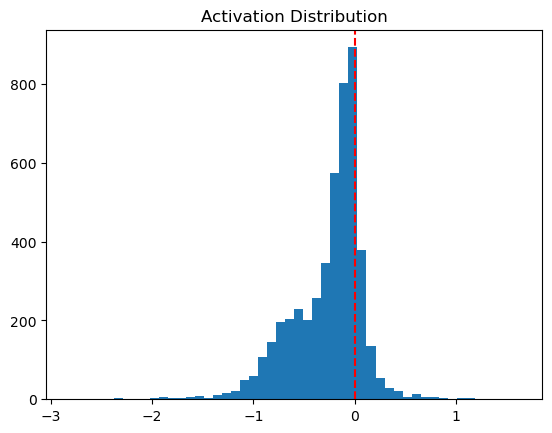

In [6]:
import matplotlib.pyplot as plt
plt.hist(all_activations.numpy(), bins=50)
plt.axvline(threshold, color='r', linestyle='dashed')
plt.title("Activation Distribution")
plt.show()

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 根据卷积层顺序准备数据
layer_names = [name for name, _ in conv_layers]
activation_grids = []  # 存储各层激活强度网格
binary_grids = []      # 存储各层二值激活网格

for layer_name in layer_names:
    # 获取当前层的激活值并转为numpy数组
    act = activations[layer_name].cpu().numpy()
    num_kernels = act.shape[0]
    
    # 计算二维网格的行列数（尽量接近正方形）
    grid_size = int(np.ceil(np.sqrt(num_kernels)))
    rows = grid_size
    cols = grid_size if grid_size**2 == num_kernels else grid_size
    
    # 填充激活强度网格
    activation_grid = np.zeros((rows, cols))
    activation_grid.flat[:num_kernels] = act
    activation_grids.append((layer_name, activation_grid))
    
    # 生成二值激活网格（阈值以上为1，反之为0）
    binary_act = (act > threshold).astype(float)
    binary_grid = np.zeros((rows, cols))
    binary_grid.flat[:num_kernels] = binary_act
    binary_grids.append((layer_name, binary_grid))

# 配置绘图参数
n_layers = len(activation_grids)
n_cols = 3  # 每行显示3个子图
n_rows = (n_layers + n_cols - 1) // n_cols
plt.rcParams['font.size'] = 8  # 调整字体大小

# ---------------------------
# 绘制激活强度图（热力图）
# ---------------------------
fig1, axs1 = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axs1 = axs1.flatten()

for idx, (name, grid) in enumerate(activation_grids):
    ax = axs1[idx]
    img = ax.imshow(grid, cmap='viridis', interpolation='nearest')
    
    # 添加标题和颜色条
    ax.set_title(f"{name}\n({activation_stats[name]['activated']}/{activation_stats[name]['total_kernels']})")
    fig1.colorbar(img, ax=ax, shrink=0.8)
    
    # 隐藏坐标轴刻度
    ax.set_xticks([])
    ax.set_yticks([])

# 隐藏多余子图
for j in range(n_layers, n_rows*n_cols):
    axs1[j].axis('off')

plt.tight_layout()
plt.savefig('activation_intensity_heatmap.png', bbox_inches='tight')
plt.close()

# ---------------------------
# 绘制二值激活图（黑白图）
# ---------------------------
fig2, axs2 = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axs2 = axs2.flatten()

for idx, (name, grid) in enumerate(binary_grids):
    ax = axs2[idx]
    img = ax.imshow(grid, cmap='gray', interpolation='nearest', vmin=0, vmax=1)
    ax.set_title(f"{name}\n{activation_stats[name]['activated']} activated")
    
    # 隐藏坐标轴刻度
    ax.set_xticks([])
    ax.set_yticks([])

# 隐藏多余子图
for j in range(n_layers, n_rows*n_cols):
    axs2[j].axis('off')

plt.tight_layout()
plt.savefig('activation_binary_map.png', bbox_inches='tight')
plt.close()

print("可视化结果已保存为 activation_intensity_heatmap.png 和 activation_binary_map.png")

可视化结果已保存为 activation_intensity_heatmap.png 和 activation_binary_map.png


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 根据卷积层顺序准备数据
layer_names = [name for name, _ in conv_layers]
activation_grids = []  # 存储各层激活强度网格
binary_grids = []      # 存储各层二值激活网格

for layer_name in layer_names:
    # 获取当前层的激活值并转为numpy数组
    act = activations[layer_name].cpu().numpy()
    num_kernels = act.shape[0]
    
    # 计算二维网格的行列数（尽量接近正方形）
    grid_size = int(np.ceil(np.sqrt(num_kernels)))
    rows = grid_size
    cols = grid_size if grid_size**2 == num_kernels else grid_size
    
    # 填充激活强度网格
    activation_grid = np.zeros((rows, cols))
    activation_grid.flat[:num_kernels] = act
    activation_grids.append((layer_name, activation_grid))
    
    # 生成二值激活网格（阈值以上为1，反之为0）
    binary_act = (act > threshold).astype(float)
    binary_grid = np.zeros((rows, cols))
    binary_grid.flat[:num_kernels] = binary_act
    binary_grids.append((layer_name, binary_grid))

# 配置绘图参数
n_layers = len(activation_grids)
n_cols = 3  # 每行显示3个子图
n_rows = (n_layers + n_cols - 1) // n_cols
plt.rcParams['font.size'] = 8  # 调整字体大小

# ---------------------------
# 绘制激活强度图（热力图）合并到一个图像
# ---------------------------
fig1, axs1 = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axs1 = axs1.flatten()

for idx, (name, grid) in enumerate(activation_grids):
    ax = axs1[idx]
    img = ax.imshow(grid, cmap='viridis', interpolation='nearest')
    
    # 添加标题和颜色条
    ax.set_title(f"{name}\n({activation_stats[name]['activated']}/{activation_stats[name]['total_kernels']})")
    fig1.colorbar(img, ax=ax, shrink=0.8)
    
    # 隐藏坐标轴刻度
    ax.set_xticks([])
    ax.set_yticks([])

# 隐藏多余子图
for j in range(n_layers, n_rows*n_cols):
    axs1[j].axis('off')

plt.tight_layout()
plt.savefig('_intensityactivation_heatmap.png', bbox_inches='tight')
plt.close()

# ---------------------------
# 绘制二值激活图（黑白图）合并到一个图像
# ---------------------------
fig2, axs2 = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axs2 = axs2.flatten()

for idx, (name, grid) in enumerate(binary_grids):
    ax = axs2[idx]
    img = ax.imshow(grid, cmap='gray', interpolation='nearest', vmin=0, vmax=1)
    ax.set_title(f"{name}\n{activation_stats[name]['activated']} activated")
    
    # 隐藏坐标轴刻度
    ax.set_xticks([])
    ax.set_yticks([])

# 隐藏多余子图
for j in range(n_layers, n_rows*n_cols):
    axs2[j].axis('off')

plt.tight_layout()
plt.savefig('activation_binary_map.png', bbox_inches='tight')
plt.close()

print("可视化结果已保存为 activation_intensity_heatmap.png 和 activation_binary_map.png")

可视化结果已保存为 activation_intensity_heatmap.png 和 activation_binary_map.png


In [15]:
import os
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import csv

def process_images_directory(directory_path, output_csv):
    """
    处理指定目录下的所有图像，提取卷积层的激活情况，并将结果保存为CSV文件。
    
    参数：
        directory_path (str): 包含图像的目录路径。
        output_csv (str): 输出CSV文件的路径。
    """
    # 加载预训练模型
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.eval()

    # 提取所有卷积层
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            conv_layers.append((name, module))

    if not conv_layers:
        raise ValueError("没有找到卷积层，请检查模型结构。")

    # 定义图像预处理函数
    def preprocess_image(image_path):
        try:
            img = Image.open(image_path).convert("RGB")
            preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            input_tensor = preprocess(img).unsqueeze(0)
            return input_tensor
        except Exception as e:
            print(f"预处理图像 {image_path} 时出错: {e}")
            return None

    # 定义钩子函数
    def get_activation(name):
        def hook(module, input, output):
            activations[name] = output.detach().mean(dim=(0, 2, 3))  # [C] 维
        return hook

    # 为所有卷积层注册钩子
    handles = []
    for name, layer in conv_layers:
        handle = layer.register_forward_hook(get_activation(name))
        handles.append(handle)

    # 用于存储所有图像的激活统计信息
    all_activation_stats = []

    # 遍历目录中的所有图像文件
    for filename in os.listdir(directory_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(directory_path, filename)
            try:
                # 初始化 activations 字典
                activations = {}

                # 预处理图像
                input_image = preprocess_image(image_path)
                if input_image is None:
                    continue  # 跳过处理失败的图像

                # 执行前向传播
                with torch.no_grad():
                    model(input_image)

                # 移除钩子（可选，但建议清理）
                for handle in handles:
                    handle.remove()

                if not activations:
                    print(f"图像 {image_path} 没有捕获到激活值，请检查钩子是否正确注册。")
                    continue

                # 定义激活阈值（例如：全局平均值的50%）
                all_activations = torch.cat([act.flatten() for act in activations.values()])
                threshold = all_activations.mean().item() * 0.5  # 可调参数
                threshold = 0  # 设置为0，表示记录所有激活的卷积核

                # 统计每个卷积层的激活情况
                activation_stats = {}
                for layer_name, act in activations.items():
                    activated_kernels = (act > threshold).nonzero().squeeze().tolist()
                    if isinstance(activated_kernels, int):
                        activated_kernels = [activated_kernels]
                    activation_stats[layer_name] = {
                        "total_kernels": len(act),
                        "activated": len(activated_kernels),
                        "indices": activated_kernels
                    }

                # 保存当前图像的激活统计信息
                all_activation_stats.append({
                    "image_path": image_path,
                    "activation_stats": activation_stats
                })

            except Exception as e:
                print(f"处理图像 {image_path} 时出错: {e}")

    # 将结果保存为CSV文件
    if all_activation_stats:
        with open(output_csv, 'w', newline='') as csvfile:
            # 获取所有卷积层的名称
            layer_names = [name for name, _ in conv_layers]
            fieldnames = ["image_path"] + layer_names
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            for stats in all_activation_stats:
                row = {"image_path": stats["image_path"]}
                for layer_name, layer_stats in stats["activation_stats"].items():
                    row[layer_name] = f"{layer_stats['activated']}/{layer_stats['total_kernels']}"
                writer.writerow(row)

# 示例用法
directory_path = r"D:\python\pure\test\clean"  # 替换为你的图像目录路径
output_csv = r"test_activation_stats.csv"  # 替换为输出CSV文件路径
process_images_directory(directory_path, output_csv)

图像 D:\python\pure\test\clean\ILSVRC2012_val_00000002.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000003.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000004.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000005.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000006.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000007.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000008.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000009.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000010.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000011.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000012.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000013.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00000109.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000110.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000111.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000112.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000113.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000114.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000115.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000116.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000117.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000118.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000119.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000120.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00000215.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000216.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000217.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000218.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000219.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000220.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000221.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000222.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000223.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000224.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000225.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000226.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00000322.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000323.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000324.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000325.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000326.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000327.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000328.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000329.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000330.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000331.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000332.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000333.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00000425.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000426.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000427.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000428.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000429.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000430.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000431.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000432.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000433.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000434.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000435.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000436.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00000530.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000531.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000532.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000533.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000534.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000535.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000536.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000537.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000538.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000539.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000540.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000541.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00000635.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000636.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000637.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000638.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000639.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000640.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000641.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000642.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000643.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000644.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000645.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000646.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00000740.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000741.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000742.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000743.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000744.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000745.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000746.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000747.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000748.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000749.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000750.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000751.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00000845.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000846.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000847.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000848.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000849.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000850.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000851.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000852.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000853.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000854.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000855.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000856.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00000952.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000953.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000954.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000955.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000956.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000957.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000958.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000959.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000960.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000961.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000962.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00000963.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00001059.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001060.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001061.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001062.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001063.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001064.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001065.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001066.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001067.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001068.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001069.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001070.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00001164.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001165.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001166.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001167.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001168.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001169.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001170.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001171.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001172.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001173.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001174.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001175.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00001271.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001272.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001273.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001274.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001275.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001276.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001277.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001278.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001279.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001280.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001281.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001282.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00001375.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001376.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001377.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001378.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001379.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001380.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001381.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001382.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001383.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001384.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001385.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001386.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00001480.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001481.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001482.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001483.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001484.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001485.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001486.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001487.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001488.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001489.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001490.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001491.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00001585.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001586.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001587.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001588.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001589.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001590.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001591.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001592.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001593.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001594.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001595.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001596.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00001691.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001692.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001693.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001694.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001695.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001696.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001697.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001698.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001699.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001700.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001701.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001702.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00001796.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001797.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001798.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001799.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001800.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001801.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001802.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001803.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001804.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001805.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001806.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001807.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00001899.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001900.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001901.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001902.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001903.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001904.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001905.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001906.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001907.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001908.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001909.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00001910.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00002004.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002005.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002006.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002007.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002008.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002009.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002010.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002011.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002012.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002013.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002014.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002015.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00002109.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002110.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002111.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002112.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002113.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002114.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002115.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002116.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002117.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002118.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002119.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002120.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00002213.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002214.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002215.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002216.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002217.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002218.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002219.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002220.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002221.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002222.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002223.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002224.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00002317.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002318.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002319.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002320.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002321.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002322.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002323.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002324.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002325.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002326.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002327.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002328.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00002420.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002421.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002422.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002423.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002424.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002425.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002426.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002427.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002428.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002429.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002430.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002431.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00002526.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002527.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002528.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002529.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002530.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002531.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002532.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002533.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002534.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002535.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002536.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002537.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00002633.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002634.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002635.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002636.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002637.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002638.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002639.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002640.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002641.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002642.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002643.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002644.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00002738.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002739.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002740.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002741.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002742.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002743.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002744.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002745.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002746.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002747.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002748.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002749.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00002844.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002845.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002846.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002847.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002848.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002849.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002850.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002851.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002852.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002853.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002854.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002855.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00002948.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002949.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002950.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002951.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002952.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002953.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002954.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002955.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002956.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002957.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002958.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00002959.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00003055.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003056.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003057.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003058.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003059.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003060.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003061.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003062.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003063.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003064.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003065.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003066.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00003162.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003163.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003164.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003165.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003166.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003167.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003168.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003169.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003170.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003171.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003172.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003173.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00003265.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003266.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003267.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003268.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003269.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003270.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003271.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003272.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003273.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003274.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003275.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003276.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00003370.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003371.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003372.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003373.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003374.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003375.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003376.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003377.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003378.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003379.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003380.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003381.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00003473.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003474.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003475.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003476.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003477.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003478.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003479.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003480.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003481.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003482.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003483.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003484.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00003576.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003577.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003578.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003579.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003580.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003581.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003582.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003583.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003584.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003585.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003586.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003587.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00003683.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003684.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003685.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003686.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003687.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003688.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003689.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003690.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003691.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003692.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003693.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003694.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00003789.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003790.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003791.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003792.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003793.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003794.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003795.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003796.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003797.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003798.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003799.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003800.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00003894.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003895.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003896.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003897.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003898.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003899.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003900.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003901.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003902.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003903.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003904.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00003905.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00004000.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004001.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004002.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004003.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004004.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004005.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004006.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004007.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004008.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004009.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004010.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004011.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00004104.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004105.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004106.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004107.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004108.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004109.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004110.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004111.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004112.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004113.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004114.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004115.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00004210.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004211.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004212.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004213.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004214.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004215.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004216.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004217.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004218.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004219.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004220.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004221.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00004316.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004317.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004318.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004319.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004320.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004321.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004322.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004323.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004324.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004325.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004326.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004327.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00004420.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004421.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004422.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004423.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004424.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004425.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004426.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004427.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004428.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004429.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004430.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004431.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00004523.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004524.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004525.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004526.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004527.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004528.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004529.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004530.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004531.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004532.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004533.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004534.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00004628.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004629.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004630.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004631.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004632.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004633.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004634.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004635.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004636.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004637.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004638.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004639.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00004732.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004733.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004734.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004735.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004736.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004737.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004738.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004739.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004740.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004741.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004742.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004743.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00004835.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004836.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004837.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004838.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004839.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004840.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004841.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004842.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004843.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004844.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004845.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004846.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_

图像 D:\python\pure\test\clean\ILSVRC2012_val_00004940.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004941.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004942.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004943.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004944.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004945.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004946.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004947.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004948.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004949.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004950.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_val_00004951.JPEG 没有捕获到激活值，请检查钩子是否正确注册。
图像 D:\python\pure\test\clean\ILSVRC2012_